<a href="https://colab.research.google.com/github/ptkoo/machineLearningJourney/blob/main/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook will walk you through training and evaluation pipline in PyTorch

If running on Colab, go to `Runtime` -> `Change runtime type` -> select GPU accelerator.

In [ ]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch import nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

torch.__version__

'2.3.1+cu121'

Let's first focus on a toy example to introduce simple training pipeline and data loader.

In [ ]:
# toy data
X = np.arange(50, 100, 0.5)
y = np.arange(5, 10, 0.05) + np.random.normal(size=len(X), scale=0.5)

In [ ]:
df = pd.DataFrame({"X": X, "y": y})
df

,X,y
0,50.0,5.042001
1,50.5,5.327842
2,51.0,4.800804
3,51.5,5.848191
4,52.0,5.302992
...,...,...
95,97.5,9.649357
96,98.0,10.016358
97,98.5,9.963036
98,99.0,9.539155


<Axes: xlabel='X', ylabel='y'>

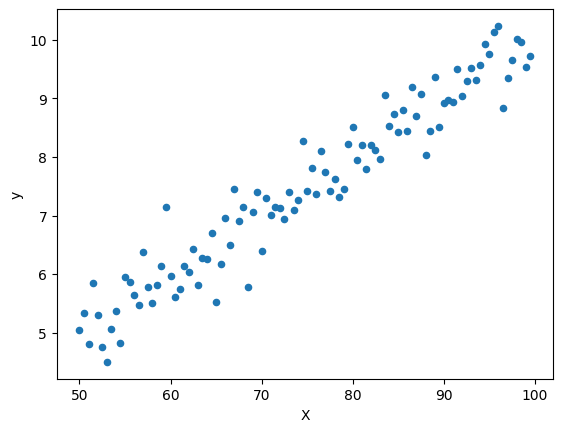

In [ ]:
df.plot.scatter(x='X', y='y')

A custom Dataset class must implement three functions: __init__, __len__, and __getitem__.

In [ ]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

dataset = MyDataset(X, y)

We define our neural network by subclassing nn.Module, and initialize the neural network layers in __init__. Every nn.Module subclass implements the operations on input data in the forward method.

In [ ]:
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # to make w and b real parameters of the model, wrap them with nn.Parameter
        self.w = torch.nn.Parameter(torch.randn(1, requires_grad=True))
        self.b = torch.nn.Parameter(torch.randn(1, requires_grad=True))

    def forward(self, x):
        return self.w * x + self.b

Now that we have a model and data it's time to train our model by optimizing its parameters on our data. Training a model is an iterative process; in each iteration the model makes a guess about the output, calculates the error in its loss, collects the derivatives of the error with respect to its parameters, and optimizes these parameters using gradient descent.

In [ ]:
model = LinearRegression()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()

batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
size = len(dataloader.dataset)

# Set the model to training mode - important for batch normalization and dropout layers
# Unnecessary in this situation but added for best practices
model.train()

losses = []
epochs = 500
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  batch_losses = []
  for batch, (X_train, y_train) in enumerate(dataloader):
      # Compute prediction and loss
      pred = model(X_train)
      loss = loss_fn(pred, y_train)
      batch_losses.append(loss.item())

      # Backpropagation
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      current = batch * batch_size + len(X_train)
      print(f"loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")

  losses.append(np.mean(batch_losses))

Epoch 1
-------------------------------
loss: 580.601096  [   32/  100]
loss: 507.060053  [   64/  100]
loss: 480.111246  [   96/  100]
loss: 497.866047  [  100/  100]
Epoch 2
-------------------------------
loss: 432.366479  [   32/  100]
loss: 374.649407  [   64/  100]
loss: 369.809662  [   96/  100]
loss: 352.468281  [  100/  100]
Epoch 3
-------------------------------
loss: 315.987394  [   32/  100]
loss: 294.516866  [   64/  100]
loss: 238.576163  [   96/  100]
loss: 239.148667  [  100/  100]
Epoch 4
-------------------------------
loss: 215.719705  [   32/  100]
loss: 200.332334  [   64/  100]
loss: 160.450568  [   96/  100]
loss: 180.310633  [  100/  100]
Epoch 5
-------------------------------
loss: 145.795438  [   32/  100]
loss: 119.713829  [   64/  100]
loss: 105.949929  [   96/  100]
loss: 96.468293  [  100/  100]
Epoch 6
-------------------------------
loss: 78.092886  [   32/  100]
loss: 72.782890  [   64/  100]
loss: 62.864710  [   96/  100]
loss: 76.038979  [  100/  10

Let's plot the loss for each epoch

<Axes: xlabel='Epoch', ylabel='Loss'>

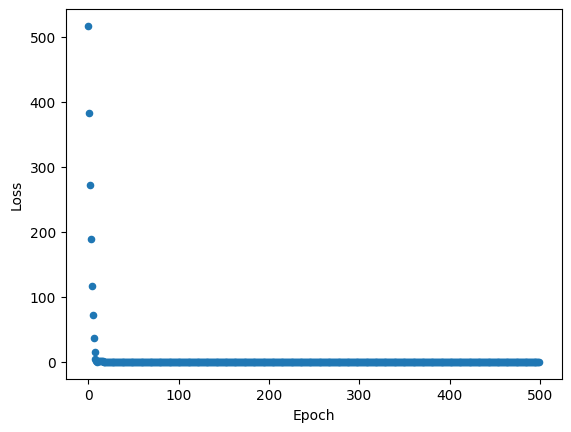

In [ ]:
df = pd.DataFrame({"Epoch": np.arange(epochs), "Loss": losses})
df.plot.scatter(x='Epoch', y='Loss')

Let's see how the model fits the data (X)

<Axes: xlabel='X', ylabel='y_pred'>

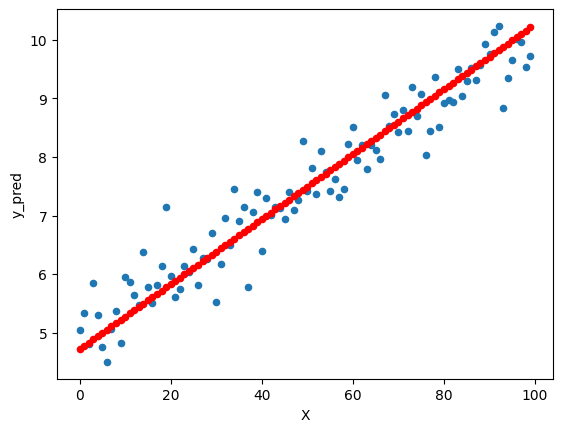

In [ ]:
with torch.no_grad():
  y_pred = model(X).numpy()

df = pd.DataFrame({"X": np.arange(size), "y_true": y, "y_pred": y_pred})
ax1 = df.plot.scatter(x='X', y='y_true')
df.plot.scatter(x='X', y='y_pred', ax=ax1, c='r')

# Training and Evaluation with FashionMNIST Dataset

Here is an example of how to load the [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset from TorchVision

In [ ]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

batch_size = 64
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

100%|██████████| 26421880/26421880 [00:06<00:00, 4367015.09it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 193847.49it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3623406.18it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5359214.94it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



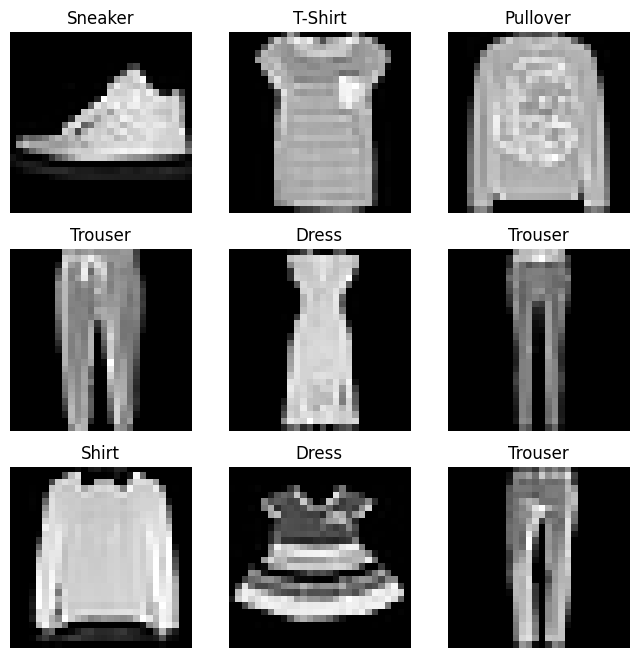

In [ ]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # convert each 2D 28x28 image into a contiguous array of 784 pixel values
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),  # The linear layer is a module that applies a linear transformation on the input using its stored weights and biases.
            nn.ReLU(), # Non-linear activations are what create the complex mappings between the model’s inputs and outputs.
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)

**Hyperparameters**

Hyperparameters are adjustable parameters that let you control the model optimization process. Different hyperparameter values can impact model training and convergence rates

We define the following hyperparameters for training:

*Number of Epochs* - the number times to iterate over the dataset

*Batch Size* - the number of data samples propagated through the network before the parameters are updated

*Learning Rate* - how much to update models parameters at each batch/epoch. Smaller values yield slow learning speed, while large values may result in unpredictable behavior during training.

In [ ]:
lr = 0.01
batch_size = 64
epochs = 10

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Once we set our hyperparameters, we can then train and optimize our model with an optimization loop. Each iteration of the optimization loop is called an epoch.

Each epoch consists of two main parts:

The Train Loop - iterate over the training dataset and try to converge to optimal parameters.

The Validation/Test Loop - iterate over the test dataset to check if model performance is improving.

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.290632  [   64/60000]
loss: 0.438731  [ 6464/60000]
loss: 0.767462  [12864/60000]
loss: 0.503643  [19264/60000]
loss: 0.614556  [25664/60000]
loss: 0.481763  [32064/60000]
loss: 0.440622  [38464/60000]
loss: 0.583328  [44864/60000]
loss: 0.264557  [51264/60000]
loss: 0.434787  [57664/60000]
Test Error: 
 Accuracy: 80.9%, Avg loss: 0.530106 

Epoch 2
-------------------------------
loss: 0.457658  [   64/60000]
loss: 0.413893  [ 6464/60000]
loss: 0.405678  [12864/60000]
loss: 0.577931  [19264/60000]
loss: 0.369017  [25664/60000]
loss: 0.463332  [32064/60000]
loss: 0.461562  [38464/60000]
loss: 0.378340  [44864/60000]
loss: 0.335165  [51264/60000]
loss: 0.683989  [57664/60000]
Test Error: 
 Accuracy: 84.1%, Avg loss: 0.438485 

Epoch 3
-------------------------------
loss: 0.285657  [   64/60000]
loss: 0.349276  [ 6464/60000]
loss: 0.337026  [12864/60000]
loss: 0.296013  [19264/60000]
loss: 0.397018  [25664/60000]
loss: 0.291287  [32064/600

In [ ]:
test_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

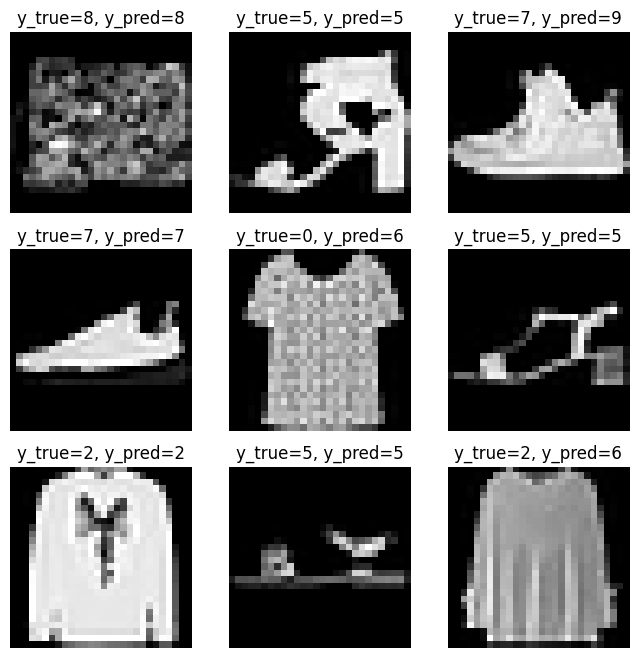

In [ ]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_data), size=(1,)).item()
    img, label = test_data[sample_idx]
    img = img.to(device)
    with torch.no_grad():
      y_pred = model(img).cpu()
    pred = y_pred.argmax(1).item()
    figure.add_subplot(rows, cols, i)
    plt.title(f"y_true={label}, y_pred={pred}")
    plt.axis("off")
    plt.imshow(img.cpu().squeeze(), cmap="gray")
plt.show()

# Can we do better?

Yes, CNNs to the rescue

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        # print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = NeuralNetwork().to(device)

In [ ]:
model

NeuralNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
batch_size = 64
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.305995  [   64/60000]
loss: 0.919186  [ 6464/60000]
loss: 0.619301  [12864/60000]
loss: 0.361480  [19264/60000]
loss: 0.688637  [25664/60000]
loss: 0.614602  [32064/60000]
loss: 0.528312  [38464/60000]
loss: 0.626665  [44864/60000]
loss: 0.394519  [51264/60000]
loss: 0.482850  [57664/60000]
Test Error: 
 Accuracy: 81.1%, Avg loss: 0.499726 

Epoch 2
-------------------------------
loss: 0.334491  [   64/60000]
loss: 0.323549  [ 6464/60000]
loss: 0.441168  [12864/60000]
loss: 0.487654  [19264/60000]
loss: 0.433000  [25664/60000]
loss: 0.523502  [32064/60000]
loss: 0.380147  [38464/60000]
loss: 0.411621  [44864/60000]
loss: 0.281191  [51264/60000]
loss: 0.269777  [57664/60000]
Test Error: 
 Accuracy: 84.6%, Avg loss: 0.413072 

Epoch 3
-------------------------------
loss: 0.326394  [   64/60000]
loss: 0.763249  [ 6464/60000]
loss: 0.571108  [12864/60000]
loss: 0.359388  [19264/60000]
loss: 0.435472  [25664/60000]
loss: 0.542596  [32064/600

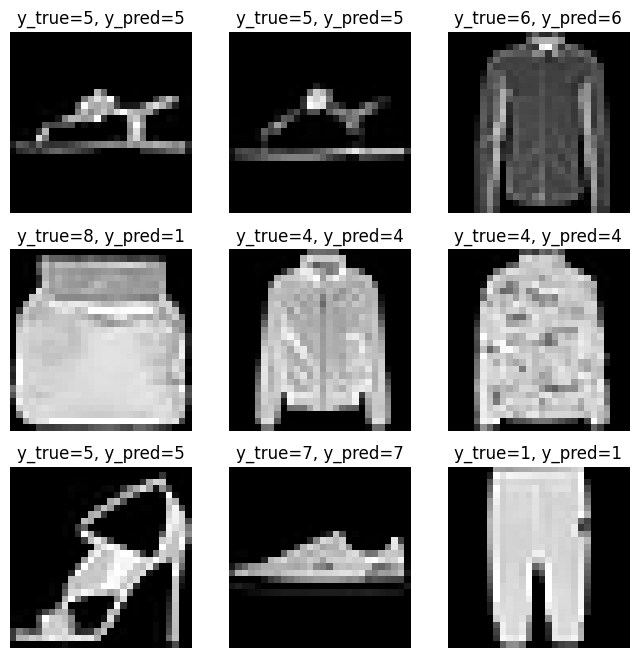

In [ ]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_data), size=(1,)).item()
    img, label = test_data[sample_idx]
    img = img.to(device)
    with torch.no_grad():
      y_pred = model(img[None, :]).cpu()
    pred = y_pred.argmax(1).item()
    figure.add_subplot(rows, cols, i)
    plt.title(f"y_true={label}, y_pred={pred}")
    plt.axis("off")
    plt.imshow(img.cpu().squeeze(), cmap="gray")
plt.show()

# Exercise:

1 Can you try to improve the test accuracy.

2 Follow the tutorial here. https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

Hints: When defining a network, use `.shape` to debug the tensor dimensions.